# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from tensorflow.image import resize
from sklearn.model_selection import train_test_split

In [6]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  7097k      0  0:00:13  0:00:13 --:--:--  9.9M
total 144
-rw-r--r--     1 sachalehmann  staff      0 Jun 29 09:15 README.md
-rw-r--r--@    1 sachalehmann  staff  73463 Jun 30 09:10 image_denoising.ipynb
drwx------  1087 sachalehmann  staff  34784 Jun  9 15:06 paintings
drwxr-xr-x     3 sachalehmann  staff     96 Jun 29 09:15 tests


In [7]:
import glob

dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

['./paintings/Joan_Miro_48.jpg',
 './paintings/Titian_232.jpg',
 './paintings/Amedeo_Modigliani_30.jpg',
 './paintings/Frida_Kahlo_21.jpg',
 './paintings/Marc_Chagall_59.jpg',
 './paintings/Salvador_Dali_116.jpg',
 './paintings/Vincent_van_Gogh_363.jpg',
 './paintings/Paul_Klee_47.jpg',
 './paintings/Kazimir_Malevich_106.jpg',
 './paintings/Leonardo_da_Vinci_7.jpg',
 './paintings/Francisco_Goya_199.jpg',
 './paintings/Vincent_van_Gogh_161.jpg',
 './paintings/Paul_Klee_90.jpg',
 './paintings/Paul_Cezanne_24.jpg',
 './paintings/Peter_Paul_Rubens_42.jpg',
 './paintings/Amedeo_Modigliani_184.jpg',
 './paintings/Titian_52.jpg',
 './paintings/Alfred_Sisley_165.jpg',
 './paintings/Paul_Gauguin_72.jpg',
 './paintings/Vincent_van_Gogh_767.jpg',
 './paintings/Raphael_106.jpg',
 './paintings/Pablo_Picasso_78.jpg',
 './paintings/Diego_Rivera_10.jpg',
 './paintings/Pieter_Bruegel_108.jpg',
 './paintings/Hieronymus_Bosch_25.jpg',
 './paintings/Joan_Miro_6.jpg',
 './paintings/Kazimir_Malevich_79.jpg'

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

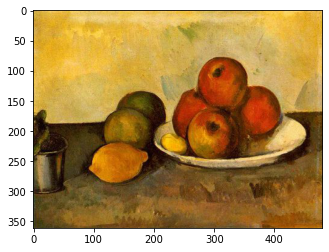

In [8]:
with Image.open(dataset_paths[54]) as im:
  plt.imshow(im)

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [9]:
a = np.asarray(im)
img_shape = a.shape[0:2]
img_dim = a.shape[2]

❓ **What was in the image above?**

In [12]:
img_shape = img_shape
img_dim = img_dim

# Uncomment the correct answer

#is_portrait = True
is_portrait = False

is_colored_image = True
#is_colored_image = False

In [13]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [17]:
from tqdm import tqdm

dataset_images = []

for img in tqdm(dataset_paths):
    with Image.open(img) as im:
        a = np.asarray(im)
        dataset_images.append(a)

100%|██████████| 1085/1085 [00:11<00:00, 97.39it/s]


### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

In [30]:
dim_list = []
for img in dataset_images:
    dim_list.append(img.shape[-1])
    
set(dim_list)

{3,
 300,
 307,
 338,
 387,
 388,
 401,
 430,
 433,
 451,
 455,
 460,
 464,
 471,
 480,
 483,
 490,
 494,
 510,
 577,
 642,
 644,
 708,
 754,
 812,
 833,
 850,
 851,
 874,
 891,
 893,
 896,
 911,
 918,
 924,
 946,
 951,
 1054,
 1229,
 1373,
 1536}

In [32]:
'''We notice that the majority of images are in color and thus have 3 dimensions. However some of them are in black and white, hence having only one dimension (reason why we have their width in the list above - their dimension being 1 it is not included in their shape)'''

'We notice that the majority of images are in color and thus have 3 dimensions. However some of them are in black and white, hence having only one dimension (reason why we have their width in the list above - their dimension being 1 it is not included in their shape)'

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [33]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in tqdm(dataset_images)]
set([x.ndim for x in dataset_images])

100%|██████████| 1085/1085 [00:01<00:00, 759.61it/s]


{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [57]:
dataset_resized = [resize(x, [120,100]).numpy() for x in dataset_images]

In [58]:
dataset_resized[342].shape

(120, 100, 3)

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [84]:
dataset_scaled = [x/255 for x in dataset_resized]

In [87]:
dataset_scaled = np.array(dataset_scaled)

In [90]:
dataset_scaled.shape

(1085, 120, 100, 3)

### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [91]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(1085, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

Text(0.5, 1.0, 'Noisy image')

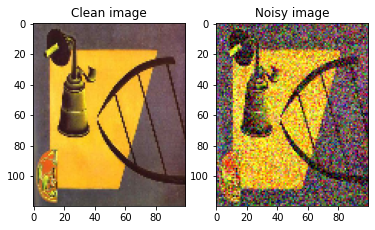

In [132]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(dataset_scaled[0])
ax1.set_title('Clean image')

ax2.imshow(dataset_noisy[0])
ax2.set_title('Noisy image')

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [130]:
np.array(dataset_images).shape

(1085,)

In [133]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_noisy, dataset_scaled, test_size = 0.2)

Text(0.5, 1.0, 'Noisy image')

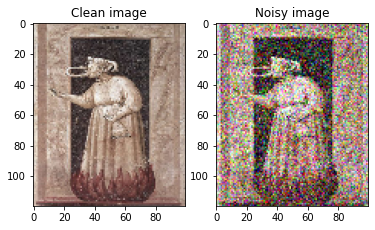

In [135]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(Y_train[10])
ax1.set_title('Clean image')

ax2.imshow(X_train[10])
ax2.set_title('Noisy image')

In [137]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [138]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [139]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [228]:
# CODE HERE YOUR ENCODER ARCHITECTURE AND PRINT IT'S MODEL SUMMARY

encoder = Sequential(name = 'encoder')
encoder.add(layers.Conv2D(16, (10,10), activation = 'relu', strides = (2,2), input_shape = (120, 100, 3)))
encoder.add(layers.MaxPool2D(2))
encoder.add(layers.Conv2D(32, (6,6), activation = 'relu', strides = (2,2)))
encoder.add(layers.MaxPool2D(2))
encoder.add(layers.Dropout(0.2))
encoder.add(layers.Conv2D(64, (2,2), activation = 'relu'))
encoder.add(layers.MaxPool2D(2))
encoder.add(layers.Dropout(0.3))
encoder.add(layers.Flatten())
encoder.add(layers.Dense(latent_dimensions, activation='tanh'))

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 56, 46, 16)        4816      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 28, 23, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 12, 9, 32)         18464     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 6, 4, 32)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 6, 4, 32)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 5, 3, 64)          8256      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 2, 1, 64)          0   

👉 **Test your encoder below**

In [229]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 6000)              805536    
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 812,211
Trainable params: 812,211
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [215]:
Y_pred = X_test

error_list = []

for img in tqdm(range(len(Y_pred))):
    for i in range(Y_pred.shape[1]):
        for j in range(Y_pred.shape[2]):
            for k in range(Y_pred.shape[3]):
                error_list.append(abs(Y_pred[img,i,j,k] - Y_test[img,i,j,k]))

100%|██████████| 217/217 [00:13<00:00, 16.65it/s]


In [217]:
score_baseline = sum(error_list)/len(error_list)

score_baseline

0.14070119591081318

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [218]:
from tensorflow.keras.optimizers import Adam

def compile_model(model):
    
    adam = Adam(learning_rate=0.01)
    
    model.compile(optimizer = adam, loss = 'mse', metrics = 'mae')
    
    return model

In [230]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 5, restore_best_weights=True, monitor='val_mae', mode = 'min')

autoencoder = compile_model(autoencoder)

history = autoencoder.fit(X_train, Y_train, validation_split = 0.2, callbacks = [es], epochs = 150, batch_size = 32, verbose = 2)

Epoch 1/150
22/22 - 15s - loss: 0.0740 - mae: 0.2335 - val_loss: 0.0706 - val_mae: 0.2288
Epoch 2/150
22/22 - 14s - loss: 0.0711 - mae: 0.2283 - val_loss: 0.0716 - val_mae: 0.2246
Epoch 3/150
22/22 - 15s - loss: 0.0650 - mae: 0.2166 - val_loss: 0.0632 - val_mae: 0.2121
Epoch 4/150
22/22 - 15s - loss: 0.0610 - mae: 0.2060 - val_loss: 0.0576 - val_mae: 0.2013
Epoch 5/150
22/22 - 15s - loss: 0.0582 - mae: 0.2014 - val_loss: 0.0629 - val_mae: 0.2086
Epoch 6/150
22/22 - 14s - loss: 0.0573 - mae: 0.1986 - val_loss: 0.0687 - val_mae: 0.2174
Epoch 7/150
22/22 - 14s - loss: 0.0548 - mae: 0.1934 - val_loss: 0.0533 - val_mae: 0.1914
Epoch 8/150
22/22 - 14s - loss: 0.0520 - mae: 0.1860 - val_loss: 0.0588 - val_mae: 0.2016
Epoch 9/150
22/22 - 14s - loss: 0.0495 - mae: 0.1810 - val_loss: 0.0670 - val_mae: 0.2126
Epoch 10/150
22/22 - 16s - loss: 0.0497 - mae: 0.1809 - val_loss: 0.0516 - val_mae: 0.1883
Epoch 11/150
22/22 - 16s - loss: 0.0483 - mae: 0.1772 - val_loss: 0.0525 - val_mae: 0.1897
Epoch 12

❓ **Plot your training and validation loss at each epoch using the cell below**

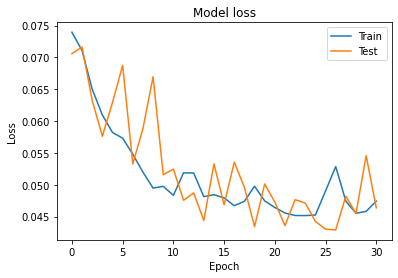

<Figure size 432x288 with 0 Axes>

In [231]:
# Plot below your train/val loss history
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    return plt.show()

plot_loss(history)

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [232]:
score = autoencoder.evaluate(X_test, Y_test)
score

7/7 [==============================] - 1s 168ms/step - loss: 0.0481 - mae: 0.1762


[0.04806502163410187, 0.17615793645381927]

In [233]:
score_test = score[1]

In [234]:
Y_pred = autoencoder.predict(X_test)

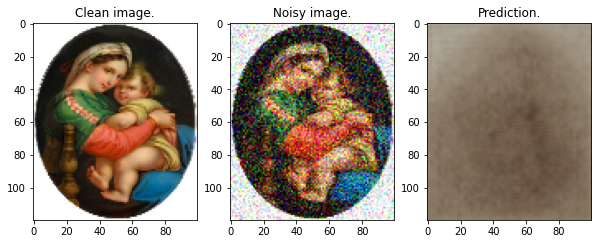

In [235]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [237]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()